In [1]:
import pandas as pd
import requests
import json
import warnings
from numpy import nan

class INEGI_BI:
    def __init__(self, token):
        self.__token = token 
        self.__url_base = 'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/'
        self.__url_indicador =  self.__url_base + 'INDICATOR/'
        self._indicadores = list() 
        self._bi = list() 
        self._columnas = list() 
        self.__clave_entidad = None
    
    def __call_api_request(self, url_api):
        requests_result = requests.get(url_api, headers={"User-Agent":self.__token})
        try:
            assert requests_result.status_code == 200, 'Favor de revisar sus parametros o token asignado, ya que no se encontró información.'
            data_serie = json.loads(requests_result.text)
            return data_serie
        except requests.exceptions.Timeout:
            warnings.warn('El tiempo de consulta se ha agotado. Favor de intentar mas tarde.')
        except requests.exceptions.TooManyRedirects:
             warnings.warn('Fallo inesperado. Favor de intentar mas tarde.')
        except requests.exceptions.RequestException as e:
             warnings.warn('Error. favor de reportar a: .')
            #raise SystemExit(e)

    def __busca_bi(self, indicador):
        if len(indicador) < 10: 
            return 'BIE'
        else: 
            return 'BISE'

    def __datos_json_api(self, indicador, bi):
        bi = self.__busca_bi(indicador)
        url_api = '{}{}/es/{}/false/{}/2.0/{}?type=json'.format(self.__url_indicador, indicador,  self.__clave_entidad, bi, str(self.__token))
        datos = self.__call_api_request(url_api)
        return datos['Series'][0], bi
    
    def __json_a_df(self, datos, bi):
        serie = datos.pop('OBSERVATIONS')

        obs_totales = len(serie)
        dic = {'periodo':[serie[i]['TIME_PERIOD'] for i in range(obs_totales)],
                'valor':[float(serie[i]['OBS_VALUE']) if serie[i]['OBS_VALUE'] is not None else nan for i in range(obs_totales)]}
        df = pd.DataFrame.from_dict(dic)
        
        frecuencia = datos['FREQ']
        #factor, period = self.__frecuancias_dict[bi].get(frecuencia)
        df.set_index(df.periodo,inplace=True, drop=True)
        df = df.drop(['periodo'],axis=1)
       
        datos['BI'] = bi
        meta = pd.DataFrame.from_dict(datos, orient='index', columns=['valor'])
        return df, meta

    def __definir_cve_ent(self, entidad):
        cve_base = '0700'
        if entidad == '00': 
            self.__clave_entidad = cve_base
            return
        if len(entidad[2:5]) == 0: 
            self.__clave_entidad = '{}00{}'.format(cve_base, entidad[:2])
        else: 
            self.__clave_entidad = '{}00{}0{}'.format(cve_base, entidad[:2], entidad[2:5])
            
    def _consulta(self, inicio, fin, bi, metadatos):
        if isinstance(self._indicadores, str): self._indicadores = [self._indicadores]
        if isinstance(self._bi, str): self._bi = [self._bi]
        if isinstance(self._columnas, str): self._columnas = [self._indicadores]
        
        lista_df = list()
        meta_dfs = list()
        
        for i in range(len(self._indicadores)):
            indicador = self._indicadores[i]
            data, bi = self. __datos_json_api(indicador, bi)
            df, meta = self.__json_a_df(data, bi)
            if bi == 'BIE': 
                df = df[::-1]
            lista_df.append(df)
            meta_dfs.append(meta)
        df = pd.concat(lista_df,axis=1)
        meta = pd.concat(meta_dfs, axis=1)
    
        try: 
            df.columns = self._columnas
            meta.columns = self._columnas
        except: 
            warnings.warn('Los nombres no coinciden con el número de indicadores')
            df.columns = self._indicadores
            meta.columns = self._indicadores

        if metadatos is False: 
            return df[inicio:fin] 
        else: 
            return df[inicio:fin], meta

    def obtener_datos(self, indicadores: 'str|list', clave_area: str = '00', inicio: str = None, 
                      fin: str = None, bi: str = None, metadatos: bool = False):
        self._indicadores = indicadores
        self._columnas = indicadores
        #if nombres is not None: 
        #self._columnas = nombres
        self.__definir_cve_ent(clave_area)
        return self._consulta(inicio, fin, bi, metadatos)

    # Metadatos
    def _consultar_catalogo(self, clave, id, bi):
        url_api = '{}{}/{}/es/{}/2.0/{}/?type=json'.format(self.__url_base, clave, id, bi, self.__token)
        request_api = requests.get(url_api)
        datos = json.loads(request_api.text)
        return pd.DataFrame(datos['CODE'])

    def catalogo_indicadores(self, bi: str, indicador: str = None):
        if indicador is None: indicador = 'null'
        return self._consultar_catalogo('CL_INDICATOR', indicador, bi)

    def consulta_metadatos(self, metadatos: 'DataFrame|dict'):
        if isinstance(metadatos, dict): metadatos = pd.DataFrame.from_dict(dict)
        n_df = metadatos.copy(deep=True)
        for col in metadatos.columns:
            bi = metadatos.loc['BI',col]
            for idx in metadatos.index: 
                if idx in ['LASTUPDATE','BI']: continue
                id = metadatos.loc[idx,col]
                if id is None or len(id) == 0: continue
                if idx == 'INDICADOR': 
                    clave = 'CL_INDICATOR'
                else: 
                    clave = 'CL_{}'.format(idx)
                try:
                    desc = self._consultar_catalogo(clave, id, bi)
                    n_df.loc[idx,col] = desc.iloc[0,1]
                except: 
                    n_df.loc[idx,col] = 'La información no existe'
        return n_df
    

In [7]:
TOKEN = "d312de10-427b-d618-3b58-f77e37afd922"
API_INEGI_BI= INEGI_BI(TOKEN)
df_poblacion = API_INEGI_BI.obtener_datos(indicadores = ["596"], inicio = '1990', fin = '2020')
display(df_poblacion)

AssertionError: Favor de revisar sus parametros o token asignado, ya que no se encontró información.

<Figure size 640x480 with 0 Axes>

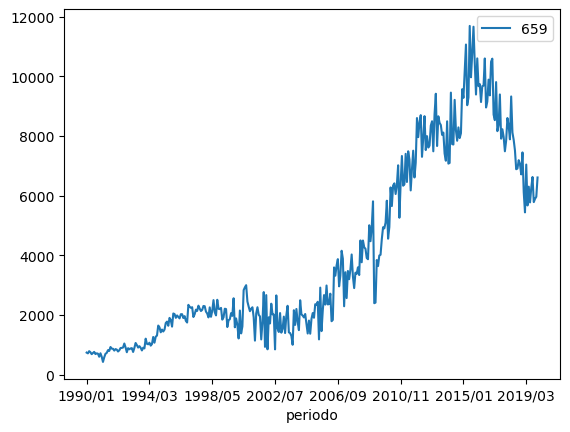

In [3]:
import matplotlib.pyplot as plt
plt.close("all")
plt.figure();
df_poblacion.plot();

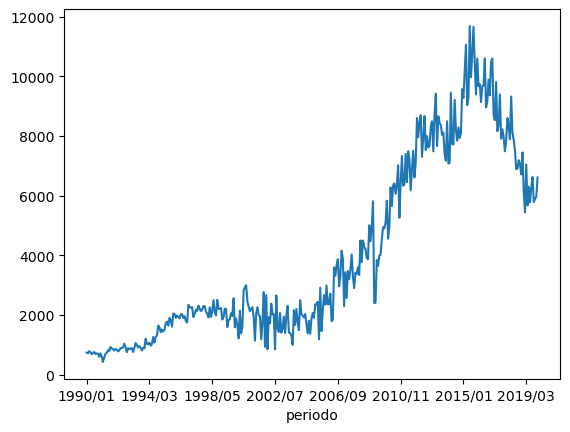

In [4]:
poblacion_total_EUM = df_poblacion["659"]
poblacion_total_EUM.plot();

In [5]:
datos, metadatos_claves = API_INEGI_BI.obtener_datos(indicadores = "659",
                                 clave_area = '01',
                                 inicio = '1980', 
                                 fin = '2020',
                                 metadatos = True)

display(datos)

,659
periodo,
1980/01,530.0
1980/02,426.0
1980/03,540.0
1980/04,570.0
1980/05,546.0
...,...
2019/08,6623.0
2019/09,5781.0
2019/10,5892.0


In [6]:
metadatos = API_INEGI_BI.consulta_metadatos(metadatos_claves)
display(metadatos)

,659
INDICADOR,Oro
FREQ,Mensual
TOPIC,La información no existe
UNIT,Kilogramos
UNIT_MULT,None
NOTE,
SOURCE,INEGI. Estadística Mensual de la Industria Min...
LASTUPDATE,21/07/2023 03:54:33 p. m.
STATUS,None
BI,BIE


# MI variación para consultar todos los indicadores del TOPIC "Migración"

In [32]:
# Obtener los indicadores en el tema de migración
indicadores_migracion = API_INEGI_BI.catalogo_indicadores(bi="BIE", indicador="130")

if indicadores_migracion is not None and len(indicadores_migracion) > 0:
    # Crear una lista para almacenar los metadatos de todos los indicadores
    all_metadatos = []

    # Iterar sobre los índices del DataFrame de indicadores
    for indicador_id in indicadores_migracion.index:
        metadatos_claves = API_INEGI_BI.catalogo_indicadores(bi="BIE", indicador=indicador_id)
        metadatos = API_INEGI_BI.consulta_metadatos(metadatos_claves)
        all_metadatos.append(metadatos)

    # Concatenar los metadatos en un DataFrame único
    df_metadatos = pd.concat(all_metadatos, axis=1)

    # Mostrar los metadatos
    display(df_metadatos)
else:
    print("No se pudieron obtener los indicadores de migración")



JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# MOstrar metadatos de indicadores específicos

In [52]:
import pandas as pd
import requests
import json
from ipywidgets import widgets
from IPython.display import display

# Definir la clase INEGI_BI y otras definiciones (omitiendo para concisión)

# API key definida en la celda anterior de INEGI donde se llama al token
api_key = TOKEN

# Crear una instancia de la clase INEGI_BI
API_INEGI_BI = INEGI_BI(api_key)

# Indicadores de interés
indicadores = ["3104003001", "6200205262", "6200205277", "6200240404", "6200240501", "6207129646"]

# Crear un DataFrame vacío para almacenar los metadatos
df_metadatos = pd.DataFrame(columns=["ID", "Título", "Descripción"])

# Función para obtener y mostrar metadatos de un indicador
def obtener_metadatos(indicadores):
    global df_metadatos
    for indicador in indicadores:
        metadatos_claves = API_INEGI_BI.catalogo_indicadores(bi="BIE", indicador=indicador)
        metadatos = API_INEGI_BI.consulta_metadatos(metadatos_claves)
        df_metadatos = df_metadatos.append({"ID": indicador, "Título": metadatos["INDICADOR"][0], "Descripción": metadatos["NOTAS"][0]}, ignore_index=True)

# Obtener metadatos para los indicadores
obtener_metadatos(indicadores)

# Función para descargar los metadatos en el formato seleccionado
def descargar_metadatos(formato):
    if formato == "CSV":
        df_metadatos.to_csv("metadatos.csv", index=False)
        print("Metadatos guardados en metadatos.csv")
    elif formato == "HTML":
        df_metadatos.to_html("metadatos.html", index=False)
        print("Metadatos guardados en metadatos.html")

# Interacción para elegir el formato de descarga
formato_descarga = widgets.Dropdown(options=["CSV", "HTML"], description='Formato:', disabled=False)
button_descargar = widgets.Button(description="Descargar")
output_descargar = widgets.Output()

def on_button_click(b):
    with output_descargar:
        descargar_metadatos(formato_descarga.value)

button_descargar.on_click(on_button_click)
widgets.VBox([formato_descarga, button_descargar, output_descargar])

# Mostrar los metadatos
display(df_metadatos)





SyntaxError: 'return' outside function (3666544902.py, line 22)